# Empirical Expected Points Added Model

#### Authors

**Iain Muir**, iam9ez  
**Hriday Singh**, hns4dc  
**Connor Smith**, cms6xs

**TODO**  
* TOC
* Style + Docstrings
* Remove unnecesary
* Data Viz

## Table of Contents

* **0. Import Libraries**
* **1. Load Data**
* **2. Feature Selection and Engineering**
    * 2.1 Remove Garbage Time
    * 2.2 Create Custom Field Position
* **3. Transform Data for Modeling**
* **4. Field Goal Model**
* **5. Punt Model**
* **6. Run Models**
* **7. Pass Models**
* **8. Expected Points Added Model**

### 0. Import Libraries

In [1]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
SEED = 42

### 1.0 Load Data

#### 1.1 Aggregate Data across Years

In [4]:
ROOT = '/Users/iainmuir/Desktop/4Y 1S/STAT 4800/Dataset/{} PFF All Plays.csv'

In [5]:
DATA = pd.DataFrame()

In [6]:
%%time

for year in range(2015, 2020):
    PATH = ROOT.format(year)
    df = pd.read_csv(PATH, low_memory=False)
    DATA = pd.concat([DATA, df])

CPU times: user 1min 3s, sys: 19.2 s, total: 1min 22s
Wall time: 3min 51s


In [7]:
DATA.shape

(758971, 177)

In [8]:
DATA.head()

,pff_PLAYID,pff_GAMEID,pff_GAMEDATE,pff_GAMESEASON,pff_WEEK,pff_GSISGAMEKEY,pff_GSISPLAYID,pff_QUARTER,pff_DOWN,pff_CLOCK,...,pff_STSAFETIES,pff_TACKLE,pff_TACKLEASSIST,pff_TEALIGNMENT,pff_TOUCHDOWN,pff_UNBLOCKEDPRESSURE,pff_VISE,pff_WRALIGNMENT,pff_PLAYCLOCK,pff_RUNPASSOPTION
0,1455513,5573,12/31/15,2015,PO,60761,35,1,0,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1455434,5573,12/31/15,2015,PO,60761,49,1,1,15:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
2,1455470,5573,12/31/15,2015,PO,60761,68,1,2,14:33,...,NaN,SCCL D15,NaN,NaN,NaN,NaN,NaN,LWR^; SRiWR; SRoWR^; RWR,NaN,0.0
3,1455450,5573,12/31/15,2015,PO,60761,90,1,3,14:03,...,NaN,SCCL D18,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0
4,1455419,5573,12/31/15,2015,PO,60761,112,1,1,13:51,...,NaN,SCCL D91,NaN,NaN,NaN,NaN,NaN,LWR; SLWR^; SRWR^; RWR,NaN,0.0


In [26]:
DATA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 758971 entries, 0 to 167026
Columns: 177 entries, pff_PLAYID to pff_RUNPASSOPTION
dtypes: float64(30), int64(30), object(117)
memory usage: 1.0+ GB


In [27]:
d = DATA.copy()

### 2.0 Feature Selection and Engineering

#### 2.1 Remove Garbage Time

In [28]:
d = d.loc[d['pff_GARBAGETIME'] == 0]

In [29]:
d = d.reset_index(drop=True)

In [30]:
d.shape

(721010, 177)

#### 2.2 Custom Field Position

In [31]:
fp = d['pff_FIELDPOSITION']
d['fp'] = np.where(fp < 0, -1 * fp, 100 - fp)

In [32]:
len(d['fp'].unique())

99

### 3.0 Transform All Data

#### 3.1 Subset Data Sets

In [33]:
PLAYS = d.loc[(d['pff_RUNPASS'] == 'P') | (d['pff_RUNPASS'] == 'R')]
FGS = d.loc[d['pff_SPECIALTEAMSTYPE'].astype(str) == 'FIELD GOAL']

In [34]:
print("Plays:", PLAYS.shape)
print("FGs:", FGS.shape)

Plays: (578355, 178)
FGs: (12548, 178)


#### 3.2 Column Transformer and Selection

###### 3.2.1 Run + Pass

In [35]:
rp = PLAYS['pff_RUNPASS']

In [36]:
INPUTS = [
    'pff_DOWN', 'pff_DISTANCE', 'pff_GAINLOSSNET', 'pff_PASSRESULT', 'fp'
]

In [37]:
model_p = PLAYS[INPUTS]

In [38]:
model_p.isnull().sum()

pff_DOWN                0
pff_DISTANCE            0
pff_GAINLOSSNET         0
pff_PASSRESULT     274374
fp                      0
dtype: int64

In [39]:
model_p['pff_PASSRESULT'] = model_p['pff_PASSRESULT'].fillna('RUN')

In [40]:
model_p.isnull().sum().sum()

0

In [41]:
print("Plays:", model_p.shape)

Plays: (578355, 5)


In [42]:
model_p.head()

,pff_DOWN,pff_DISTANCE,pff_GAINLOSSNET,pff_PASSRESULT,fp
1,1,10,-6,SACK,25
2,2,16,9,RUN,19
3,3,7,17,RUN,28
4,1,10,1,RUN,45
5,1,10,15,INCOMPLETE,46


In [43]:
TARGET = 'pff_GAINLOSSNET'
X_p = model_p.drop(TARGET, axis=1)
y_p = model_p[TARGET]

In [44]:
# num_pipeline = Pipeline([
#     ('std_scaler', StandardScaler())
# ])
# X_prep_p = num_pipeline.fit_transform(X_p)
# X_prep_p = pd.DataFrame(X_prep_p, columns=X_p.columns.tolist())
# X_prep_p = X_prep_p.join(rp.reset_index(drop=True))

In [45]:
X_prep_p = X_p.join(rp.reset_index(drop=True))

In [46]:
X_prep_p.head()

,pff_DOWN,pff_DISTANCE,pff_PASSRESULT,fp,pff_RUNPASS
1,1,10,SACK,25,R
2,2,16,RUN,19,R
3,3,7,RUN,28,R
4,1,10,RUN,45,P
5,1,10,INCOMPLETE,46,R


In [47]:
print("Plays:", X_prep_p.shape)

Plays: (578355, 5)


In [48]:
print("Plays:", y_p.shape)

Plays: (578355,)


In [49]:
X_prep_p = X_prep_p.join(y_p)

In [50]:
RUN = X_prep_p.loc[X_prep_p['pff_RUNPASS'] == 'R']
PASS = X_prep_p.loc[X_prep_p['pff_RUNPASS'] == 'P']

In [51]:
print("Run:", RUN.shape)
print("Pass:", PASS.shape)

Run: (219972, 6)
Pass: (244086, 6)


###### 3.2.2 Field Goals

In [52]:
FGS[['kickResult', 'kickLocation']] = FGS['pff_KICKRESULT'].str.split(' - ', expand=True)
FGS['kickResult'] = np.where(FGS['kickResult'] == 'MISSED', 0, 1)

In [53]:
INPUTS = [
    'pff_HASH', 'pff_KICKYARDS', 'kickResult'
]

In [54]:
model_fg = FGS[INPUTS]

In [55]:
model_fg.shape

(12548, 3)

In [56]:
model_fg = model_fg.dropna()

In [57]:
model_fg.shape

(12535, 3)

In [58]:
TARGET = 'kickResult'
X_fg = model_fg.drop(TARGET, axis=1)
y_fg = model_fg[TARGET]

In [59]:
hash_, yards = X_fg['pff_HASH'], X_fg['pff_KICKYARDS']
hash_ = np.array(hash_).reshape(-1, 1)
one_hot = OneHotEncoder(sparse=True).fit_transform(hash_).toarray()
hash_ = pd.DataFrame(one_hot, columns=['hash_C', 'hash_L', 'hash_R'])
X_prep_fg = hash_.join(yards.reset_index(drop=True).astype(int))

In [60]:
X_prep_fg.head()

,hash_C,hash_L,hash_R,pff_KICKYARDS
0,0.0,1.0,0.0,26
1,0.0,0.0,1.0,36
2,0.0,0.0,1.0,22
3,0.0,1.0,0.0,43
4,0.0,0.0,1.0,47


### 4.0 Field Goal Model

#### 4.1 Threshold Experimentation

In [61]:
def metrics(model, x, y, threshold=0.5):
    y_prob = model.predict_proba(x)[:, 1]
    predictions = np.where(y_prob > threshold, 1, 0)
    print("\nConfusion Matrix (t={})".format(threshold))
    print(confusion_matrix(y, predictions))
    f1_ = f1_score(y, predictions)
    print("F1:", f1_)

    return f1_

In [62]:
def log_reg(X, y, threshold=0.5):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2
    )

    lr = LogisticRegression(
#         random_state=SEED,
        solver='lbfgs'
    )
    lr = lr.fit(X_train, y_train)
    f1_score = metrics(lr, X_test, y_test, threshold)

    return lr, f1_score

In [63]:
thresholds = np.arange(0.5, 1.05, 0.05)
f1_scores = []
for t in thresholds:
    model, f1 = log_reg(X_prep_fg, y_fg, round(t, 2))
    f1_scores.append(f1)


Confusion Matrix (t=0.5)
[[ 138  545]
 [ 105 1719]]
F1: 0.8409980430528375

Confusion Matrix (t=0.55)
[[ 174  487]
 [ 186 1660]]
F1: 0.8314550463310794

Confusion Matrix (t=0.6)
[[ 284  406]
 [ 279 1538]]
F1: 0.8178675884073385

Confusion Matrix (t=0.65)
[[ 348  339]
 [ 363 1457]]
F1: 0.8058628318584071

Confusion Matrix (t=0.7)
[[ 377  271]
 [ 514 1345]]
F1: 0.7741007194244605

Confusion Matrix (t=0.75)
[[ 486  179]
 [ 713 1129]]
F1: 0.7168253968253967

Confusion Matrix (t=0.8)
[[519 145]
 [924 919]]
F1: 0.6322669418644652

Confusion Matrix (t=0.85)
[[ 586   63]
 [1216  642]]
F1: 0.5009754194303551

Confusion Matrix (t=0.9)
[[ 635   15]
 [1575  282]]
F1: 0.2618384401114206

Confusion Matrix (t=0.95)
[[ 724    0]
 [1779    4]]
F1: 0.0044767767207610516

Confusion Matrix (t=1.0)
[[ 665    0]
 [1842    0]]
F1: 0.0


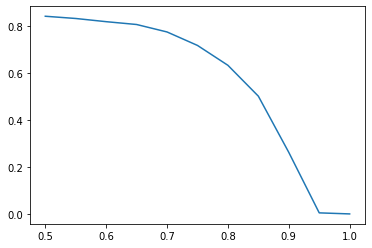

In [64]:
plt.plot(thresholds, f1_scores)
plt.show()

#### 4.2 Final Logistic Regression Model

In [65]:
BEST_THRESHOLD = 0.6

In [66]:
fg_model, f1 = log_reg(X_prep_fg, y_fg, 0.6)


Confusion Matrix (t=0.6)
[[ 270  428]
 [ 272 1537]]
F1: 0.8145204027556968


### 5.0 Punt Distributions

In [67]:
PUNTS = d.loc[d['pff_SPECIALTEAMSTYPE'] == 'PUNT'][['pff_KICKYARDS', 'pff_RETURNYARDS']]
PUNTS['pff_RETURNYARDS'] = PUNTS['pff_RETURNYARDS'].fillna(0)
PUNTS = PUNTS.dropna()

In [68]:
PUNTS.shape

(40782, 2)

In [69]:
PUNTS['NET_YARDS'] = PUNTS['pff_KICKYARDS'] - PUNTS['pff_RETURNYARDS']

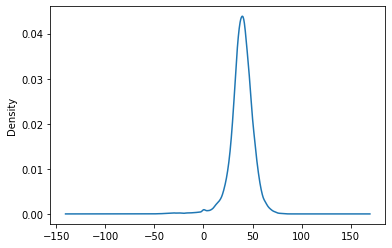

In [70]:
PUNTS['NET_YARDS'].plot.density()
plt.show()

In [71]:
x = np.array(PUNTS['NET_YARDS'])
punt_model = GaussianMixture(
        n_components=2,
#         random_state=SEED
).fit(x.reshape(-1, 1))

### 6.0 Run Models

In [72]:
RUN = RUN.drop('pff_PASSRESULT', axis=1)

In [73]:
r1 = RUN.loc[RUN['pff_DOWN'] == 1]
r2 = RUN.loc[RUN['pff_DOWN'] == 2]
r3 = RUN.loc[RUN['pff_DOWN'] == 3]
r4 = RUN.loc[RUN['pff_DOWN'] == 4]

In [74]:
print("Running Downs:")
print("\t1st:", r1.shape)
print("\t2nd:", r2.shape)
print("\t3rd:", r3.shape)
print("\t4th:", r4.shape)

Running Downs:
	1st: (96808, 5)
	2nd: (72217, 5)
	3rd: (45542, 5)
	4th: (4888, 5)


#### Calculate Median and Standard Deviation

In [75]:
r1['group'] = pd.qcut(r1['pff_DISTANCE'], q=[0, 0.05, 0.9675, 1], labels=['short', 'medium', 'long'])
r2['group'] = pd.qcut(r2['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
r3['group'] = pd.qcut(r3['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
r4['group'] = pd.qcut(r4['pff_DISTANCE'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])

In [76]:
r1_s, r1_m, r1_l = r1.loc[r1['group'] == 'short'], r1.loc[r1['group'] == 'medium'], r1.loc[r1['group'] == 'long']
r2_s, r2_m, r2_l = r2.loc[r2['group'] == 'short'], r2.loc[r2['group'] == 'medium'], r2.loc[r2['group'] == 'long']
r3_s, r3_m, r3_l = r3.loc[r3['group'] == 'short'], r3.loc[r3['group'] == 'medium'], r3.loc[r3['group'] == 'long']
r4_s, r4_m, r4_l = r4.loc[r4['group'] == 'short'], r4.loc[r4['group'] == 'medium'], r4.loc[r4['group'] == 'long']

In [77]:
print("Running Categories:")
print("\t1st:", r1.shape)
print("\t\t1st Short:", r1_s.shape)
print("\t\t1st Medium:", r1_m.shape)
print("\t\t1st Long:", r1_l.shape)
print("\t2nd:", r2.shape)
print("\t\t2nd Short:", r2_s.shape)
print("\t\t2nd Medium:", r2_m.shape)
print("\t\t2nd Long:", r2_l.shape)
print("\t3rd:", r3.shape)
print("\t\t3rd Short:", r3_s.shape)
print("\t\t3rd Medium:", r3_m.shape)
print("\t\t3rd Long:", r3_l.shape)
print("\t4th:", r4.shape)
print("\t\t4th Short:", r4_s.shape)
print("\t\t4th Medium:", r4_m.shape)
print("\t\t4th Long:", r4_l.shape)

Running Categories:
	1st: (96808, 6)
		1st Short: (5212, 6)
		1st Medium: (88477, 6)
		1st Long: (3119, 6)
	2nd: (72217, 6)
		2nd Short: (21029, 6)
		2nd Medium: (40235, 6)
		2nd Long: (10953, 6)
	3rd: (45542, 6)
		3rd Short: (11953, 6)
		3rd Medium: (25066, 6)
		3rd Long: (8523, 6)
	4th: (4888, 6)
		4th Short: (2467, 6)
		4th Medium: (1327, 6)
		4th Long: (1094, 6)


#### Mixture Models

Ref: 
* [sklearn.mixture.GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture)  
* [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
* [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
* [sklearn.pipeline.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
* [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

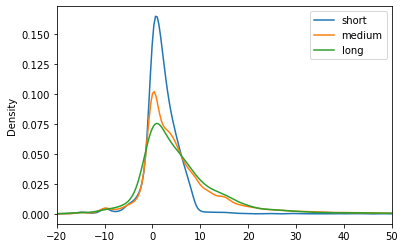

In [78]:
r1_s['pff_GAINLOSSNET'].plot.density()
r1_m['pff_GAINLOSSNET'].plot.density()
r1_l['pff_GAINLOSSNET'].plot.density()
plt.xlim(-20, 50)
plt.legend(labels=['short', 'medium', 'long'])
plt.show()

In [79]:
from sklearn.mixture import GaussianMixture

def plot_mixture(gm):
    """
    
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = np.linspace(-25, 50, 1000).reshape(1000, 1)
    logprob = gm.score_samples(x)
    pdf = np.exp(logprob)
    
    ax.plot(x, pdf, '-k')
    plt.show()
    

def mixture_model(x, plot=True):
    """
    
    """
    x = np.array(x['pff_GAINLOSSNET'])
    
    gm = GaussianMixture(
        n_components=2, 
#         random_state=SEED
    ).fit(x.reshape(-1, 1))
    
    if plot:
        plot_mixture(gm)
    
    return gm

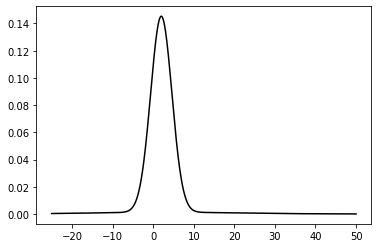

In [80]:
m = mixture_model(r1_s)

In [81]:
vals = [
    r1_s, r1_m, r1_l,
    r2_s, r2_m, r2_l,
    r3_s, r3_m, r3_l,
    r4_s, r4_m, r4_l
]
run_mixture_dict = {1: [], 2: [], 3: [], 4:[]}
run_bins = {1: [], 2: [], 3: [], 4:[]}

for i, v in enumerate(vals):
    down = i // 3 + 1
    
    m = mixture_model(v, plot=False)  
    run_mixture_dict[down].append(m)
    run_bins[down].append((min(v['pff_DISTANCE']), max(v['pff_DISTANCE']) + 1))

In [82]:
run_bins[1][0]

(1, 9)

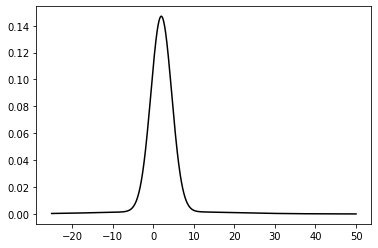

In [83]:
plot_mixture(run_mixture_dict[1][0])

In [84]:
run_mixture_dict[1][0].sample(1)[0][0][0]

3.4216191807759646

### 7.0 Pass Models

In [85]:
p1 = PASS.loc[PASS['pff_DOWN'] == 1]
p2 = PASS.loc[PASS['pff_DOWN'] == 2]
p3 = PASS.loc[PASS['pff_DOWN'] == 3]
p4 = PASS.loc[PASS['pff_DOWN'] == 4]

In [86]:
print("Passing Downs:")
print("\t1st:", p1.shape)
print("\t2nd:", p2.shape)
print("\t3rd:", p3.shape)
print("\t4th:", p4.shape)

Passing Downs:
	1st: (107682, 6)
	2nd: (79630, 6)
	3rd: (50783, 6)
	4th: (5375, 6)


#### Calculate Median and Standard Deviation

In [87]:
p1['group'] = pd.qcut(p1['pff_DISTANCE'], q=[0, 0.05, 0.9675, 1], labels=['short', 'medium', 'long'])
p2['group'] = pd.qcut(p2['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
p3['group'] = pd.qcut(p3['pff_DISTANCE'], q=[0, 0.25, 0.75, 1], labels=['short', 'medium', 'long'])
p4['group'] = pd.qcut(p4['pff_DISTANCE'], q=[0, 0.5, 0.75, 1], labels=['short', 'medium', 'long'])

In [88]:
p1_s, p1_m, p1_l = p1.loc[p1['group'] == 'short'], p1.loc[p1['group'] == 'medium'], p1.loc[p1['group'] == 'long']
p2_s, p2_m, p2_l = p2.loc[p2['group'] == 'short'], p2.loc[p2['group'] == 'medium'], p2.loc[p2['group'] == 'long']
p3_s, p3_m, p3_l = p3.loc[p3['group'] == 'short'], p3.loc[p3['group'] == 'medium'], p3.loc[p3['group'] == 'long']
p4_s, p4_m, p4_l = p4.loc[p4['group'] == 'short'], p4.loc[p4['group'] == 'medium'], p4.loc[p4['group'] == 'long']

In [89]:
print("Passing Categories:")
print("\t1st:", p1.shape)
print("\t\t1st Short:", p1_s.shape)
print("\t\t1st Medium:", p1_m.shape)
print("\t\t1st Long:", p1_l.shape)
print("\t2nd:", p2.shape)
print("\t\t2nd Short:", p2_s.shape)
print("\t\t2nd Medium:", p2_m.shape)
print("\t\t2nd Long:", p2_l.shape)
print("\t3rd:", p3.shape)
print("\t\t3rd Short:", p3_s.shape)
print("\t\t3rd Medium:", p3_m.shape)
print("\t\t3rd Long:", p3_l.shape)
print("\t4th:", p4.shape)
print("\t\t4th Short:", p4_s.shape)
print("\t\t4th Medium:", p4_m.shape)
print("\t\t4th Long:", p4_l.shape)

Passing Categories:
	1st: (107682, 7)
		1st Short: (5775, 7)
		1st Medium: (98432, 7)
		1st Long: (3475, 7)
	2nd: (79630, 7)
		2nd Short: (22910, 7)
		2nd Medium: (44483, 7)
		2nd Long: (12237, 7)
	3rd: (50783, 7)
		3rd Short: (13319, 7)
		3rd Medium: (27965, 7)
		3rd Long: (9499, 7)
	4th: (5375, 7)
		4th Short: (3173, 7)
		4th Medium: (991, 7)
		4th Long: (1211, 7)


In [90]:
vals = [
    p1_s, p1_m, p1_l,
    p2_s, p2_m, p2_l,
    p3_s, p3_m, p3_l,
    p4_s, p4_m, p4_l
]
pass_mixture_dict = {1: [], 2: [], 3: [], 4:[]}
pass_bins = {1: [], 2: [], 3: [], 4:[]}

for i, v in enumerate(vals):
    down = i // 3 + 1
    
    m = mixture_model(v, plot=False)  
    pass_mixture_dict[down].append(m)
    pass_bins[down].append((min(v['pff_DISTANCE']), max(v['pff_DISTANCE']) + 1))

In [91]:
pass_bins[1][0]

(1, 9)

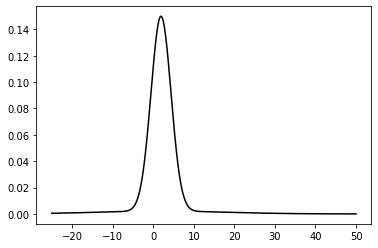

In [92]:
plot_mixture(pass_mixture_dict[1][0])

### 8.0 Expected Points Added Model

In [228]:
SEED = 42
PCT_RUN = 0.5
AGGRESSION = 0

In [229]:
def EPA(down, ytg, position, pct_run=0.5, aggression=0):
    """
    @param - down:
    @param - ytg:
    @param - position:
    @param - own:
    """
    global reverse
    
    points = list()
    
    SIMULATIONS = 100
    for i in range(SIMULATIONS):
        reverse = False
        
        point = run_play(down, ytg, position, pct_run, aggression)
        points.append(point)
    
    return np.array(points).mean()

In [230]:
def run_play(down, ytg, position, pct_run, aggression):
    """
    @param - down:
    @param - ytg:
    @param - position:
    """
    global reverse
    
    choices = ['run', 'pass']
    choice = np.random.choice(choices, 1, p=[pct_run, 1 - pct_run])[0]

    bins = run_bins if choice == 'run' else pass_bins
    models = run_mixture_dict if choice == 'run' else pass_mixture_dict
    
    try:
        idx = [i for i, b in enumerate(bins[down]) if ytg in range(b[1])][0]
    except IndexError:
        idx = 2
    
    model = models[down][idx]
    
#     print(down, ytg, position)
    
    if down == 4:
        # Go For It
        if aggression >= idx and position > 40:
            yards_gained = round(model.sample(1)[0][0][0], 0)
            position += yards_gained
            
            # Converted
            if yards_gained >= ytg:
                down, ytg = 1, 10
#                 print("\tConverted:", yards_gained, "yards gained")
                return run_play(down, ytg, position, pct_run, aggression)
            
            # Turnover on Downs
            else:
                reverse = not reverse
                down, ytg = 1, 10
#                 print("\tTurnover on Downs:", yards_gained, "yards gained")
                return run_play(down, ytg, 100 - position, pct_run, aggression)
                
        # Field Goal
        elif (position >= 60) or (50 >= position < 60 and AGGRESSION == 2):
            hash_ = list(np.zeros(3))
            hash_[np.random.randint(0, 3)] = 1
            hash_.extend([100 - position + 17])
            result = fg_model.predict(np.array(hash_).reshape(1, -1))[0]
            
#             print('Kicking Field Goal...')
            if result == 0:
                reverse = not reverse
                down, ytg = 1, 10
                return run_play(down, ytg, 100 - position, pct_run, aggression)
            else:
                score = True
                scored = 3
            
        # Punt
        else:
            net_yards = round(punt_model.sample(1)[0][0][0], 0)
            position += net_yards
            
#             print('Punting...', net_yards)
            # Punt Returned for TD
            if position < 0:
                score = True
                scored = -7
            # Touchback
            elif position >= 100:
                down, ytg = 1, 10
                return run_play(down, ytg, 25, pct_run, aggression)
            else:
                reverse = not reverse
                down, ytg = 1, 10
                return run_play(down, ytg, 100 - position, pct_run, aggression)
        
    else:
        yards_gained = round(model.sample(1)[0][0][0], 0)
        position += yards_gained
#         print("\t", yards_gained, "yards gained")
        
        # Touchdown
        if position >= 100:
#             print('TOUCHDOWN!')
            score = True
            scored = 7
            
        # Safety
        elif position <= 0:
#             print('SAFETY!')
            score = True
            scored = -2
            
        # First Down
        elif yards_gained >= ytg:
            down, ytg = 1, 10
            return run_play(down, ytg, position, pct_run, aggression)
        else:
            return run_play(down + 1, ytg - yards_gained, position, pct_run, aggression)
    
    ret = scored if not reverse else -scored
#     print(ret)
    return ret

In [231]:
down = 1
ytg = 10
position = 10

In [233]:
STATE = {
    'down': down,
    'ytg': ytg,
    'position': position,
    'pct_run': PCT_RUN,
    'aggression': AGGRESSION
}

In [234]:
%%time

epa = EPA(**STATE)

CPU times: user 1.93 s, sys: 62.8 ms, total: 1.99 s
Wall time: 12.2 s


In [236]:
print('''
    Expected Points Model:
    S (Down: {}, YTG: {}, Position: {}) == {} EP
'''.format(
    STATE['down'],
    STATE['ytg'],
    ('Own ' if STATE['position'] < 50 else '') + 
    str(STATE['position'] if STATE['position'] < 50 else 100 - STATE['position']),
    epa
))


    Expected Points Model:
    S (Down: 1, YTG: 10, Position: Own 10) == -0.6 EP



Hriday Completion %

Short

In [ ]:
[0.40185185185185185,
 0.387123745819398,
 0.3518578352180937,
 0.40397350993377484]

Medium

In [ ]:
[0.3900100908173562,
 0.3751466944842874,
 0.3601001915426551,
 0.2967032967032967]

Long

In [ ]:
[0.28287841191067,
 0.2672672672672673,
 0.22920517560073936,
 0.30869565217391304]

### 9.0 Data Viz

In [242]:
DOWNS = [1, 2, 3, 4]
YARDS = [2, 5, 10]
POSITION = list(range(10, 100, 10))
PCT_RUN = [0.25, 0.5, 0.75]
AGGRESSION = [0, 1, 2]

In [243]:
import itertools
states = np.array(
    list(itertools.product(DOWNS, YARDS, POSITION, PCT_RUN, AGGRESSION))
)

In [244]:
states.shape

(972, 5)

In [245]:
states

array([[ 1.  ,  2.  , 10.  ,  0.25,  0.  ],
       [ 1.  ,  2.  , 10.  ,  0.25,  1.  ],
       [ 1.  ,  2.  , 10.  ,  0.25,  2.  ],
       ...,
       [ 4.  , 10.  , 90.  ,  0.75,  0.  ],
       [ 4.  , 10.  , 90.  ,  0.75,  1.  ],
       [ 4.  , 10.  , 90.  ,  0.75,  2.  ]])

In [246]:
def call_epa(inputs):
    """
    @param inputs — 
    """
    epa = EPA(*inputs)
#     print("Inputs:", inputs, " | EPA:", epa)
    
    return epa

In [247]:
%%time

epa_vect = np.vectorize(call_epa, signature='(n)->()')
epa_lst = epa_vect(np.array(states))

CPU times: user 10min 47s, sys: 7.6 s, total: 10min 55s
Wall time: 11min 51s


In [248]:
epa_lst

array([ 0.28,  0.55, -0.14,  0.42,  0.49,  0.66,  0.45, -0.03,  1.12,
        0.55,  1.62,  1.75,  1.18,  1.03,  0.7 ,  0.73,  0.76,  1.03,
        1.65,  1.35,  1.91,  2.36,  1.28,  1.68,  1.38,  1.99,  1.3 ,
        2.26,  1.26,  1.44,  2.44,  3.43,  0.88,  3.01,  2.54,  2.33,
        3.18,  2.25,  2.89,  3.44,  3.83,  2.01,  2.76,  3.28,  3.22,
        4.02,  4.91,  3.86,  4.56,  3.16,  3.63,  3.47,  3.51,  3.03,
        3.68,  4.72,  3.5 ,  5.29,  4.76,  4.2 ,  4.51,  4.39,  4.15,
        5.61,  5.76,  4.57,  5.16,  4.58,  4.71,  4.99,  5.85,  4.75,
        5.91,  6.15,  6.39,  5.88,  5.63,  5.69,  6.18,  6.26,  6.06,
        1.01, -0.02,  0.44,  0.02,  1.11,  1.14, -0.63,  0.77, -0.12,
        1.1 ,  1.13,  1.91,  0.5 ,  0.51,  0.79,  1.52,  0.78, -0.37,
        1.75,  2.44,  2.25,  1.02,  1.37,  0.37,  1.53,  1.74,  2.33,
        2.67,  3.06,  2.57,  2.43,  2.07,  2.28,  0.83,  2.99,  1.07,
        2.49,  2.81,  1.91,  2.5 ,  2.92,  3.36,  3.2 ,  3.05,  3.26,
        4.49,  4.32,

In [249]:
states_df = pd.DataFrame(
    states, columns=['down', 'yard', 'position', 'percent_run', 'aggression']
)

In [250]:
states_df['epa'] = epa_lst

In [254]:
states_df.to_csv('states.csv')